### Hotel in Jeju 
<strong>&nbsp;&nbsp;&nbsp;jeju hotel guest consumption eda</strong>
- 1급 호텔 (4,5 성급)
- 2급 호텔 (2,3 성급)
- 기타 숙박업 (1성급, 기타 표시되지 않은 숙박업종 중 기준 충족되는 업소)

<strong>&nbsp;&nbsp;&nbsp;Datas</strong>
1. 제주도 내 숙박 업종 분포 (2020.05 ~ 2020.08 기준)<br>
- 이용 횟수, 숙박 업종 내 총 매출에서 1급 호텔이 가장 낮다. <br>
2. 제주 데이터 허브 내국인 관광객 지역, 업종, 성별, 연령대별 카드 이용 데이터 (2017.01 ~ 2018.12.31)

<br>
<strong>&nbsp;&nbsp;&nbsp;Hypotheses</strong><br><br>
&nbsp;1. 1급 호텔과 다른 숙박 업종의 bill 단가를 비교했을 때 가격 차이가 크지 않을 것이다.<br>
&nbsp;2. 1급 호텔이 관광객 주 소비 지역과 가까이 위치하지 않을 것이다.<br>
&nbsp;3. 1급 호텔이 다른 숙박 업종에 비해 군집을 이루지 않았을 것이다.<br>

In [2]:
import pandas as pd
import numpy as np
from pyproj import Proj, transform
import matplotlib 
import dask.dataframe as dd

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [3]:
detailed_data_url = '../datas/detailed_consume_type_data.csv'
detailed_data = pd.read_csv(detailed_data_url, sep=',')

detailed_data.tail(3)

,YM,Sido,Sigungu,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,LargeCategory,MediumCategory
273180,202005,제주특별자치도,제주시,영세,편의점,x시,4800,0,1,0,950266.5976,1502457.688,소매업,체인화 편의점
273181,202005,제주특별자치도,제주시,중소,제과점,x시,25000,0,2,0,950524.6587,1500759.566,소매업,빵 및 과자류 소매업
273182,202005,제주특별자치도,제주시,영세,서양음식,x시,6000,0,1,0,950674.5989,1500760.286,음식점업,서양식 음식점업


0. 제주 내 영향력있는 업종 (업종별 소비자 수, 소비횟수, 소비금액)

In [4]:
# 음식점업 기준 소분류, 중분류 총 이용 횟수, 총 이용 금액
restaurant_df = detailed_data[detailed_data['LargeCategory'] == '음식점업']

restaurant_pivot = restaurant_df.pivot_table(
    index=['MediumCategory', 'Type'], 
    values=['TotalSpent','NumofSpent', 'NumofDisSpent'], aggfunc='sum')
restaurant_pivot.sort_values('TotalSpent', axis=0, ascending=False)

NumofDisSpent  NumofSpent   TotalSpent
MediumCategory          Type                                         
한식 음식점업                 일반한식          120291      778824  28245133753
서양식 음식점업                서양음식           47854      420297   6000328366
일식 음식점업                 일식회집            5898       42528   2481301181
기타 주점업                  유흥주점               0       11498   2202130396
피자, 햄버거, 샌드위치 및 유사 음식점업 스넥             20283      114005   2049269707
중식 음식점업                 중국음식           10322       53597   1402394438
일반유흥 주점업                단란주점               0        6696   1182642040
                        주점              2433       23158    945025619
기타 주점업                  칵테일바               0        2343    168112330
일반유흥 주점업                주류판매점             44         783     46899750

2. 제주 데이터 허브 (내국인, 관광객 업종별 소비내역)

In [5]:
consumption_data_url = '../datas/jeju_api_res_datas.csv'
consumption_data = pd.read_csv(consumption_data_url, sep=',',
                              names=['sigungu', 'marketType', 'userType', 'gender', 'userCount', 'useCount', 'useCost'])

consumption_data.rename(columns= consumption_data.iloc[0])
consumption_data.reset_index(drop=True).tail(3)

,sigungu,marketType,userType,gender,userCount,useCount,useCost
16697,제주시,소매,제주도민,남,806,1125,74823494
16698,제주시,문화/레져,내국인관광객,여,877,971,16823000
16699,제주시,숙박,내국인관광객,남,194,276,28666770


제주도민 대분류별 

- 업종 이용 횟수, 소비자 수, 총 소비 금액

In [6]:
local_df = consumption_data[consumption_data['userType']=='제주도민'].reset_index(drop=True)

# 제주도민 업종별 평균 이용 횟수
local_sum_pivot = (local_df.pivot_table(index='marketType', values=['useCount', 'useCost', 'userCount'], aggfunc='sum')
               .add_prefix('localSum_')).astype(int)

local_sum_pivot

,localSum_useCost,localSum_useCount,localSum_userCount
marketType,,,
교통,235596728034,4238506,2652361
기타,274323891778,4170118,2098008
문화/레져,68918393547,1888397,1214628
소매,273535648466,3718984,2393921
쇼핑,585591553849,28799681,8560011
숙박,31680115747,319313,224588
식음료,529335154776,18827193,8518080
유흥,109368275375,951247,656706


내국인 관광객 대분류별 
- 업종 이용 횟수, 소비자 수, 총 소비 금액

In [7]:
guest_df = consumption_data[consumption_data['userType']=='내국인관광객'].reset_index(drop=True)

# 내국인관광객 업종별 평균 이용 횟수
guest_sum_pivot = (guest_df.pivot_table(index='marketType', values=['useCount', 'useCost', 'userCount'], aggfunc='sum')
               .add_prefix('guestSum_')).astype(int)

guest_sum_pivot

,guestSum_useCost,guestSum_useCount,guestSum_userCount
marketType,,,
교통,199464890198,2979060,2522923
기타,95426976177,2010343,1238926
문화/레져,68955443253,1498791,1145961
소매,137180163858,3159035,2530423
쇼핑,361605687366,14583636,7206258
숙박,100204671616,1020999,781350
식음료,393586081344,12411585,8304869
유흥,30604269530,261881,196747


local_rate : 제주도민 업종별 소비 비율<br>
guest_rate : 내국인 관광객 업종별 소비 비율

In [8]:
# 업종별 소비횟수 비율, 총 사용금액 비율, 소비자 비율
g_rate_cols = ['guest_rate_useCost', 'guest_rate_useCount', 'guest_rate_userCount']
l_rate_cols = ['local_rate_useCost', 'local_rate_useCount', 'local_rate_userCount']

guestConsume_cols = guest_sum_pivot.columns
localConsume_cols = local_sum_pivot.columns

for i in range(len(local_sum_pivot.columns)):
    guest_sum_pivot[g_rate_cols[i]] = (guest_sum_pivot[guestConsume_cols[i]] / guest_sum_pivot[guestConsume_cols[i]].sum()).astype(float) * 100
    local_sum_pivot[l_rate_cols[i]] = (local_sum_pivot[localConsume_cols[i]] / local_sum_pivot[localConsume_cols[i]].sum()).astype(float) * 100

guest_rate = guest_sum_pivot.drop(guestConsume_cols, axis=1) # 내국인 관광객
local_rate = local_sum_pivot.drop(localConsume_cols, axis=1) # 제주도민

In [9]:
total_rate = pd.concat([guest_rate, local_rate], axis=1)
total_rate.sort_values(by='local_rate_useCost', ascending=False) # 정렬

,guest_rate_useCost,guest_rate_useCount,guest_rate_userCount,local_rate_useCost,local_rate_useCount,local_rate_userCount
marketType,,,,,,
쇼핑,26.070536,38.453551,30.117108,27.774877,45.776676,32.524935
식음료,28.376214,32.726373,34.708532,25.106610,29.925551,32.365613
기타,6.879959,5.300792,5.177842,13.011309,6.628342,7.971669
소매,9.890222,8.329618,10.575395,12.973922,5.911271,9.096031
교통,14.380738,7.855067,10.544050,11.174461,6.737044,10.078009
유흥,2.206463,0.690517,0.822265,5.187388,1.511993,2.495244
문화/레져,4.971452,3.951952,4.789314,3.268831,3.001580,4.615146
숙박,7.224415,2.692130,3.265495,1.502602,0.507543,0.853353


In [10]:
# 한글 설정
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

f_path = "/Users/seyoung/Library/Fonts/AppleGothic.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

In [390]:
# matplotlib dark theme style
# from matplotlib import style

# style.available
# style.use('bmh')

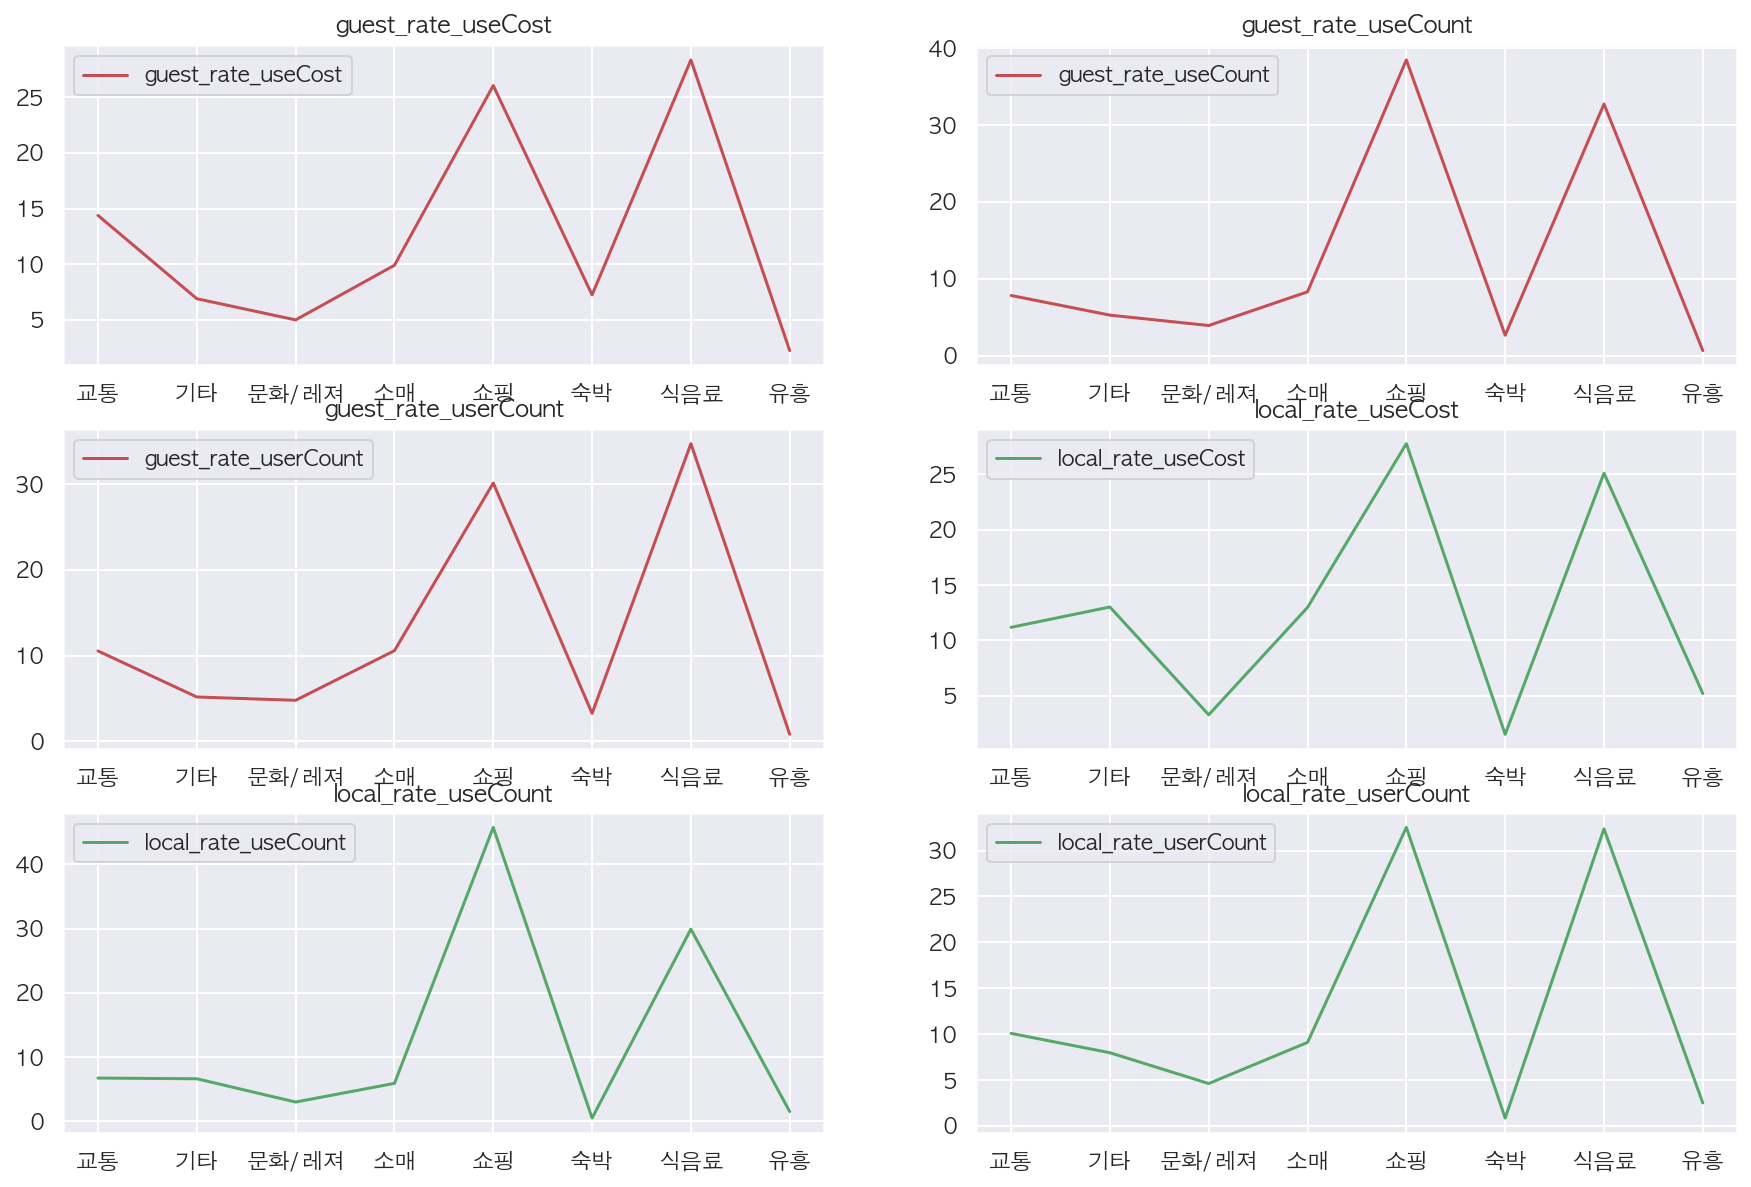

In [91]:
plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(321 + i)
    title = ax.set_title(total_rate.columns[i])

    if str(total_rate.columns[i]).startswith('guest') == True:
        c = 'r'
    else:
        c = 'g'
        
    ax.plot(total_rate.index[:], total_rate[total_rate.columns[i]], label=total_rate.columns[i], color = c)
    plt.legend(loc=2)
    
plt.show()

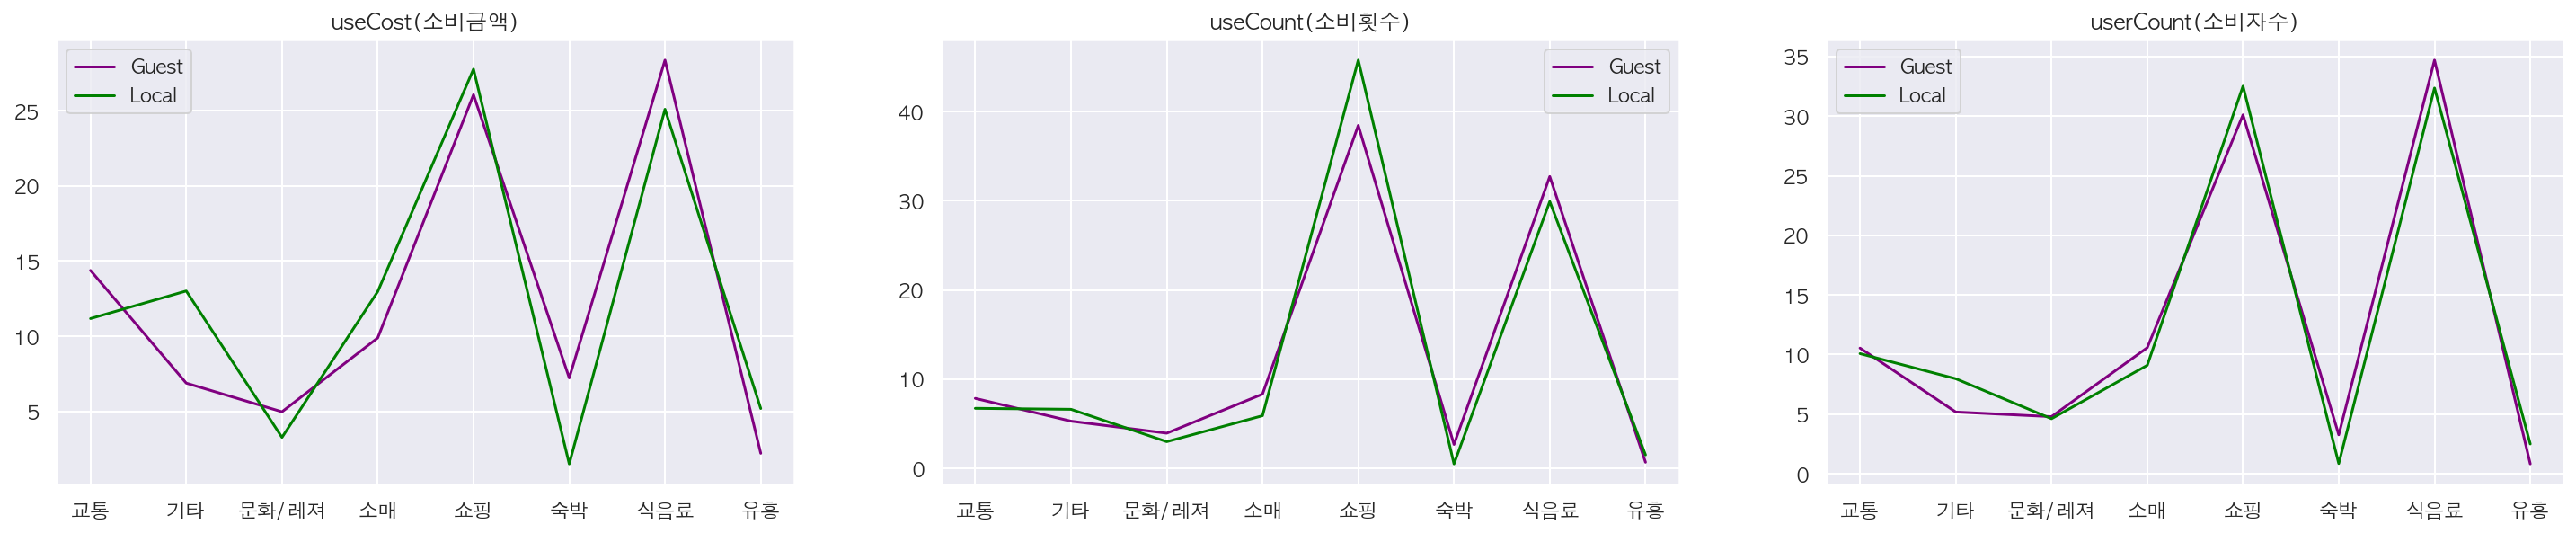

In [89]:
plt.figure(figsize=(25,10))
cols = int(len(total_rate.columns)/2)
line_labels = ['Guest', 'Local']
plt_titles = ['useCost(소비금액)', 'useCount(소비횟수)', 'userCount(소비자수)']

for i in range(cols):
    plt.subplot(2,3,i+1)
    plt.plot(total_rate.index[:], total_rate[total_rate.columns[i]], color='purple')
    plt.plot(total_rate.index[:], total_rate[total_rate.columns[i+3]], color='green')
    plt.title(plt_titles[i])
    plt.legend(labels=line_labels)

plt.show()

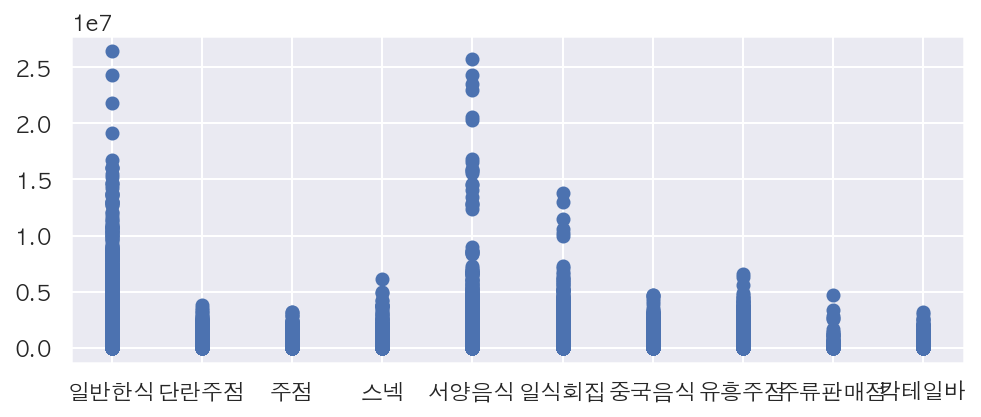

In [19]:
plt.figure(figsize=(8,3))
plt.scatter(restaurant_df['Type'], restaurant_df['TotalSpent'])

-----
### Hotel Data

In [16]:
hotel_data_url = '../datas/detailed_consume_type_data_hotel.csv'
datas = pd.read_csv(hotel_data_url, sep=',')

# Type = '콘도' 제외
datas = datas.iloc()[:,3:].reset_index(drop=True)
drop_rows = datas.index[datas['Type'] == '콘도'].tolist()
hotel_datas = datas.drop(index=drop_rows)

# TotalSpent에서 DisSpent제외한 순수매출
hotel_datas['TotalSpent'] -= hotel_datas['DisSpent']
hotel_datas.tail(3)

,Sigungu,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,LargeCategory,MediumCategory,Proj_X,Proj_Y
7370,제주시,영세,기타숙박업,x시,240000,0,2,0,921960.8140,1505970.235,숙박업,여관업,126.657295,33.545616
7374,서귀포시,영세,기타숙박업,x시,96020,0,3,0,940664.1457,1493315.085,숙박업,여관업,126.859582,33.432683
7376,서귀포시,영세,기타숙박업,x시,40000,0,1,0,947293.2310,1497145.416,숙박업,여관업,126.930666,33.467577


,Time,Type,NumofSpent,TotalSpent
0,00시,1급호텔,2,95000
1,00시,2급호텔,4,327000
2,00시,기타숙박업,564,27278391
3,00시,특급호텔,53,3855821
4,01시,1급호텔,2,122000
...,...,...,...,...
93,23시,기타숙박업,740,41263461
94,23시,특급호텔,138,11608007
95,x시,2급호텔,1,50000
96,x시,기타숙박업,47,9082677


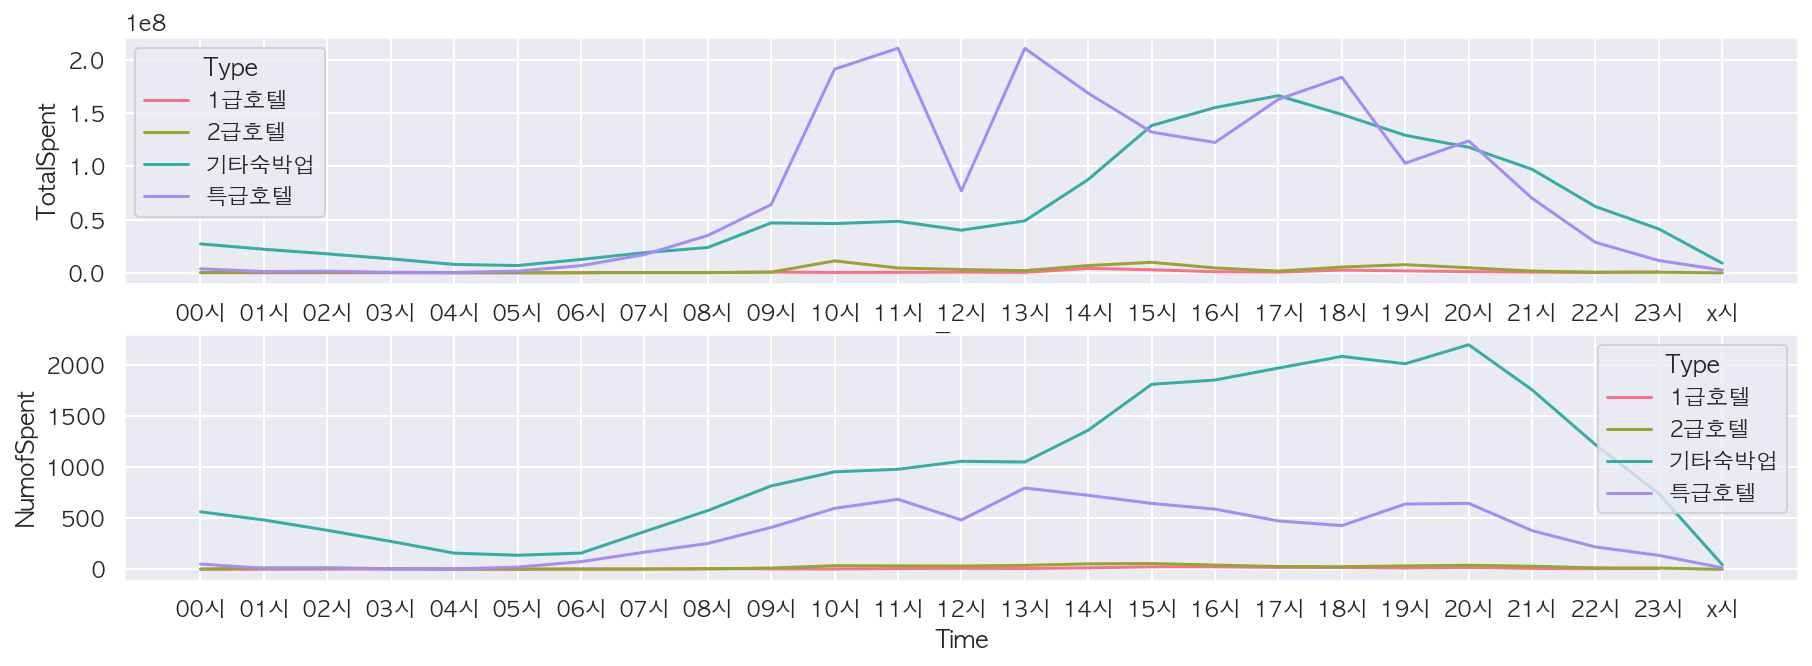

In [128]:
# Time based indexing
time_based_pivot = hotel_datas.pivot_table(index=['Time','Type'], values=['TotalSpent', 'NumofSpent'], aggfunc='sum')

# time = list(set([time_based_pivot.index[i][0] for i in range(len(time_based_pivot))]))

# time 기준 Type별 NumofSpent, TotalSpent
time_based_pivot.reset_index(inplace=True)
time_based_pivot

fig, axes = plt.subplots(2)
sns.set(rc={'figure.figsize':(15,25),'axes.unicode_minus':False}, font='AppleGothic', style='darkgrid')

with sns.color_palette('husl', 3):
    sns.lineplot(x='Time', y='TotalSpent', hue='Type', data=time_based_pivot, ax=axes[0]);
    sns.lineplot(x='Time', y='NumofSpent', hue='Type', data=time_based_pivot, ax=axes[1]);

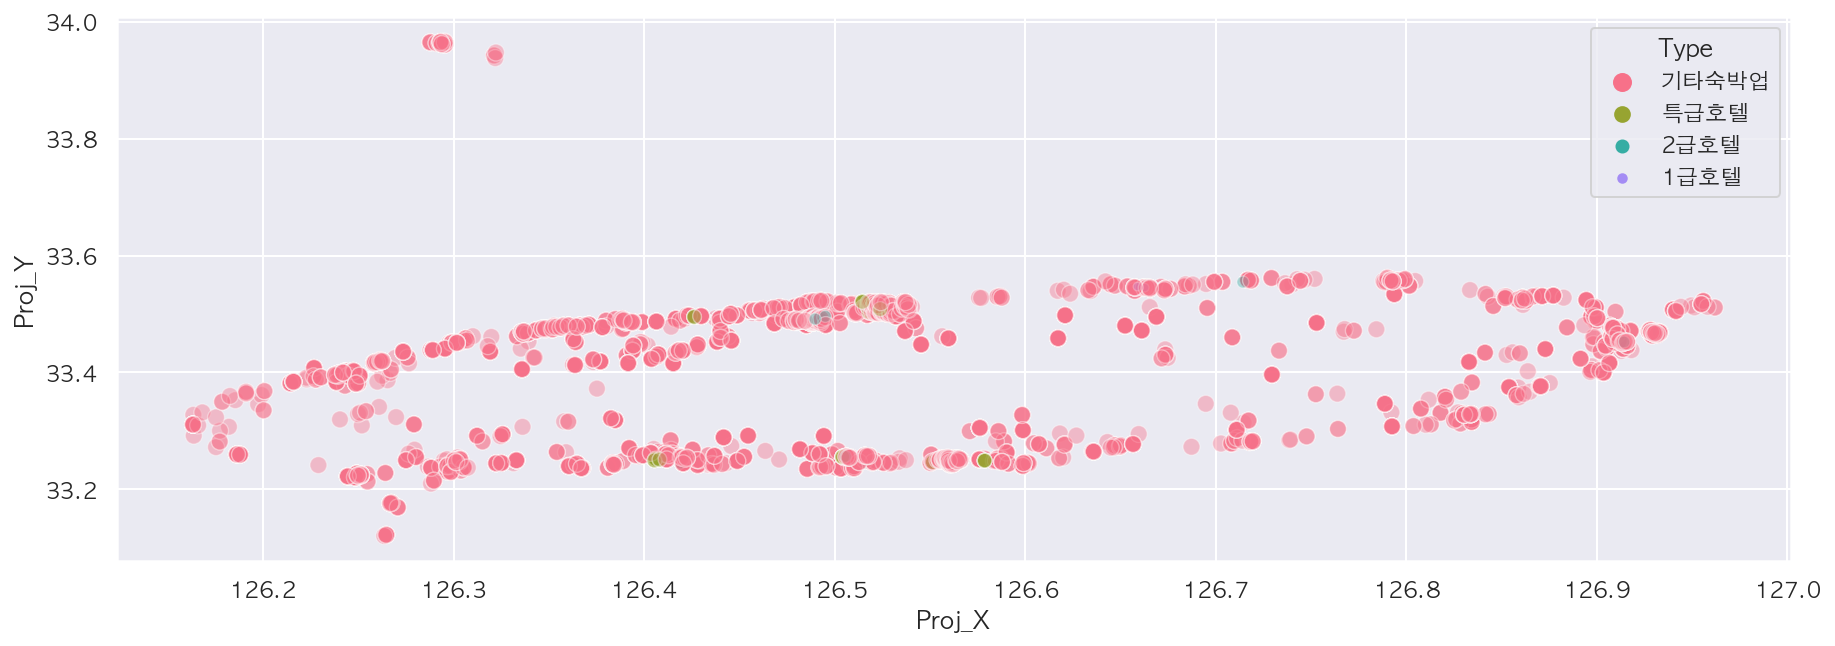

In [257]:
sns.set(rc={'figure.figsize':(15,5),'axes.unicode_minus':False}, font='AppleGothic', style='darkgrid')
with sns.color_palette('husl', 3):
    ax = sns.scatterplot(x='Proj_X', y='Proj_Y', 
                         data=hotel_datas, hue='Type', alpha=0.4, size='Type')

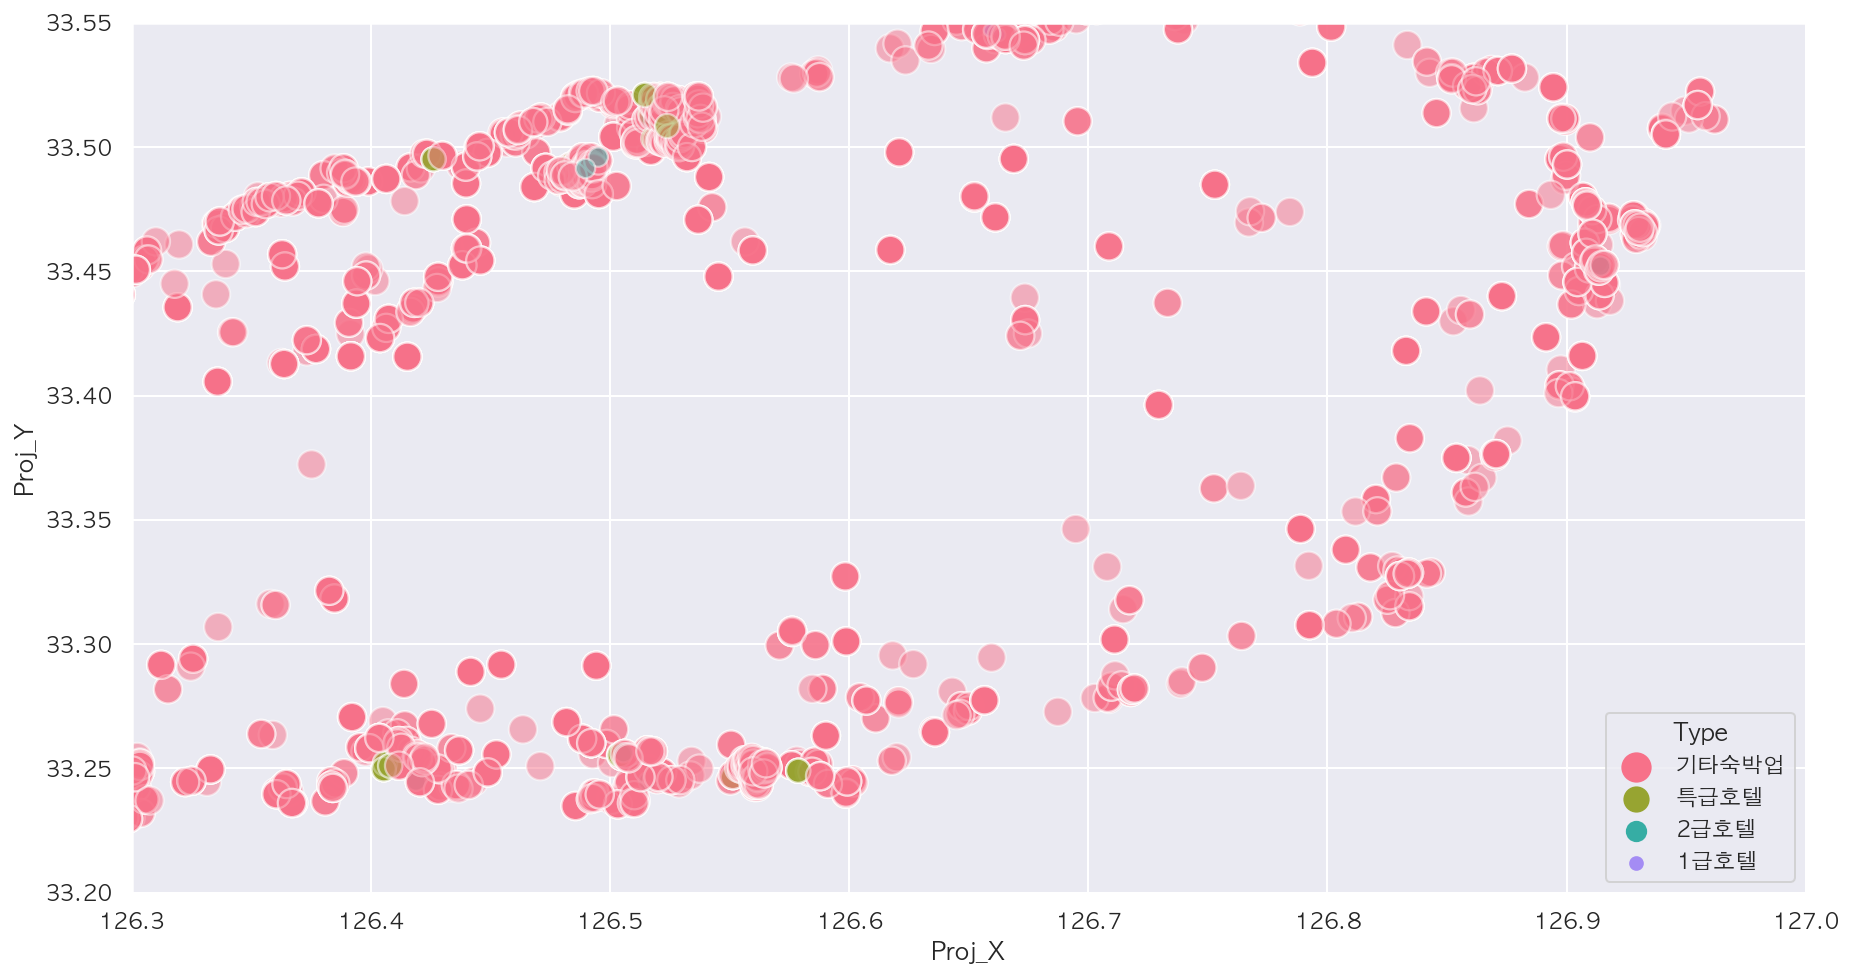

In [255]:
# xlim, ylim
sns.set(rc={'figure.figsize':(15,8),'axes.unicode_minus':False}, font='AppleGothic', style='darkgrid')
with sns.color_palette('husl', 3):
    plt = sns.scatterplot('Proj_X', 'Proj_Y',data=hotel_datas, hue='Type', alpha=0.5, size='Type', sizes=(40,200))
    plt.set(ylim=(33.2, 33.55))
    plt.set(xlim=(126.3, 127))

3. 제주도 내 숙박 업종 (2020.05 ~ 2020.08 기준) POINT_X, POINT_Y 좌표 위도, 경도 변환 수행

In [100]:
# 좌표 변환
def change_lat_lng(path_x, path_y):
    
    itrf_x, itrf_y = path_x, path_y
    
    proj_UTMK = Proj(init='epsg:5178') #기존 좌표계: ITRF2000
    proj_WGS84 = Proj(init='epsg:4326') #변환할 좌표계
    
    x, y = transform(proj_UTMK, proj_WGS84, itrf_x, itrf_y)
    latlng = (x, y)
    
    return latlng

In [101]:
raw_xy = hotel_spent[['POINT_X', 'POINT_Y']]
raw_xy

NameError: name 'hotel_spent' is not defined

In [11]:
# ITRF2000 좌표계 좌표
def get_transform_xy(raw_xy):
    transform_xy = []
    latlng_df = raw_xy
    
    for i in range(len(latlng_df)):
        raw_x = latlng_df['POINT_X'].iloc[i]
        raw_y = latlng_df['POINT_Y'].iloc[i]

        res = change_lat_lng(raw_x, raw_y)
        transform_xy.append(res)

    return transform_xy


raw_xy = hotel_spent[['POINT_X', 'POINT_Y']]
res_latlng = get_transform_xy(raw_xy)

get_x, get_y = [], []

for i in range(len(res_latlng)):
    x = str(res_latlng[i][0])
    y = str(res_latlng[i][1])
    
    get_x.append(x)
    get_y.append(y)

KeyboardInterrupt: 

In [96]:
hotel_spent['Proj_X'] = get_x
hotel_spent['Proj_Y'] = get_y

hotel_spent.reset_index(drop=True, inplace=True)
hotel_spent.tail(5)

NameError: name 'get_x' is not defined

In [ ]:
hotel_spent.to_csv("../datas/detailed_consume_type_data.csv", encoding='utf-8-sig')